In [6]:
import pandas as pd
pd.set_option("display.precision", 8)
from matplotlib import pyplot as plt
import os
from math import pi, log
from matplotlib import rcParams
rcParams["text.usetex"] = True
rcParams["figure.dpi"] = 200
rcParams["font.size"] = 18


def agglomerate_dframe(csv_filename="",study_pattern="",dframe_name=""):
    # Find all "csv_filename.csv" files in study_pattern*/ folders
    csv_files = [os.path.join(folder, csv_filename) 
                 for folder in os.listdir(os.curdir) 
                 if os.path.isfile(os.path.join(folder, csv_filename))
                 and study_pattern in folder]
    csv_files.sort()
    print(csv_files)

    # Read all "csv_filename.csv" files into a pandas.DataFrame
    dframes = []
    for csv_file in csv_files:
        dframes.append(pd.read_csv(csv_file, header=0)) 
    final_dframe = pd.concat(dframes, ignore_index=True)
    final_dframe.to_csv(dframe_name + ".csv", index=False)
    return final_dframe

# Convergence of $|V(t_0) - V_e| \quad V(t_0) := \sum_{c \in C} \alpha_c |\Omega_c|$ $V_e$ is the exact volume, using leiaSetFields.csv 



['shear2DindicatorSharpJump_00000_shear2D/leiaSetFields.csv', 'shear2DindicatorSharpJump_00001_shear2D/leiaSetFields.csv', 'shear2DindicatorSharpJump_00002_shear2D/leiaSetFields.csv', 'shear2DindicatorSharpJump_00003_shear2D/leiaSetFields.csv', 'shear2DindicatorSharpJump_00004_shear2D/leiaSetFields.csv', 'shear2DindicatorSharpJump_00005_shear2D/leiaSetFields.csv', 'shear2DindicatorSharpJump_00006_shear2D/leiaSetFields.csv']
Exact volume 7.068583e-03
Marker model volume
0    0.00625000
1    0.00742187
2    0.00693359
3    0.00708008
4    0.00706177
5    0.00707397
6    0.00706825
Name: VOL_ALPHA_0, dtype: float64
Volume error for sharpJump
0    0.11580587
1    0.04998053
2    0.01909710
3    0.00162614
4    0.00096419
5    0.00076275
6    0.00004675
Name: VOL_ALPHA_0, dtype: float64


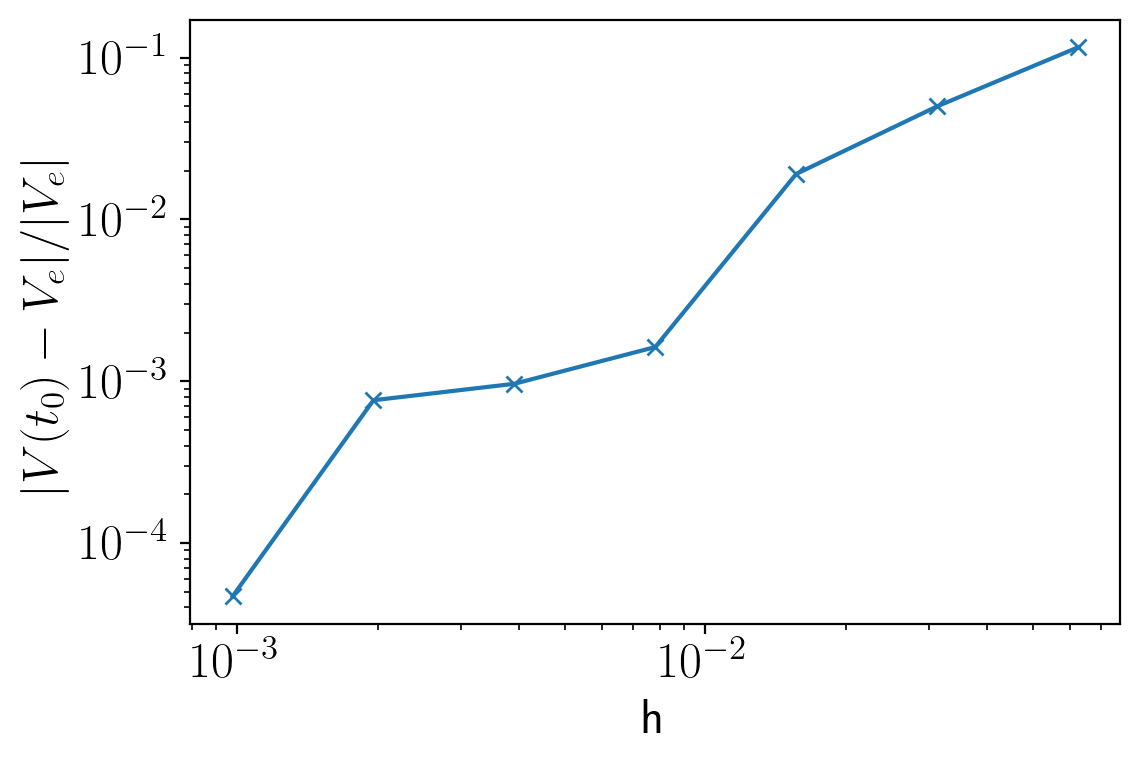

In [7]:
R = 0.15 # From the test case definition 
A = R**2 * pi
h_mesh = 0.1 # From system/blockMeshDict
V_e = A * h_mesh

sharpJump_dframe = agglomerate_dframe(csv_filename="leiaSetFields.csv",
                                      study_pattern="shear2DindicatorSharpJump",
                                      dframe_name="sharpJump")

print ("Exact volume %e" % V_e)
print ("Marker model volume")
print (sharpJump_dframe["VOL_ALPHA_0"])
volume_error_sharpJump = abs(sharpJump_dframe["VOL_ALPHA_0"] - V_e) / V_e
print ("Volume error for sharpJump")
print (volume_error_sharpJump)
plt.plot(sharpJump_dframe["H"], volume_error_sharpJump, '-x')
plt.ylabel("$|V(t_0) - V_e|/|V_e|$")
plt.xlabel("h")
plt.loglog()
plt.savefig("leiaLevelSetFoam-sharpJump-V0-error.pdf", bbox_inches="tight")

['shear2DindicatorHeaviside_00000_shear2D/leiaSetFields.csv', 'shear2DindicatorHeaviside_00001_shear2D/leiaSetFields.csv', 'shear2DindicatorHeaviside_00002_shear2D/leiaSetFields.csv', 'shear2DindicatorHeaviside_00003_shear2D/leiaSetFields.csv', 'shear2DindicatorHeaviside_00004_shear2D/leiaSetFields.csv', 'shear2DindicatorHeaviside_00005_shear2D/leiaSetFields.csv', 'shear2DindicatorHeaviside_00006_shear2D/leiaSetFields.csv']
Exact volume 7.068583e-03
Marker model volume
0    0.00742847
1    0.00715877
2    0.00709103
3    0.00707421
4    0.00706997
5    0.00706893
6    0.00706867
Name: VOL_ALPHA_0, dtype: float64
Volume error for heaviside
0    0.05091296
1    0.01275935
2    0.00317539
3    0.00079543
4    0.00019601
5    0.00004945
6    0.00001224
Name: VOL_ALPHA_0, dtype: float64


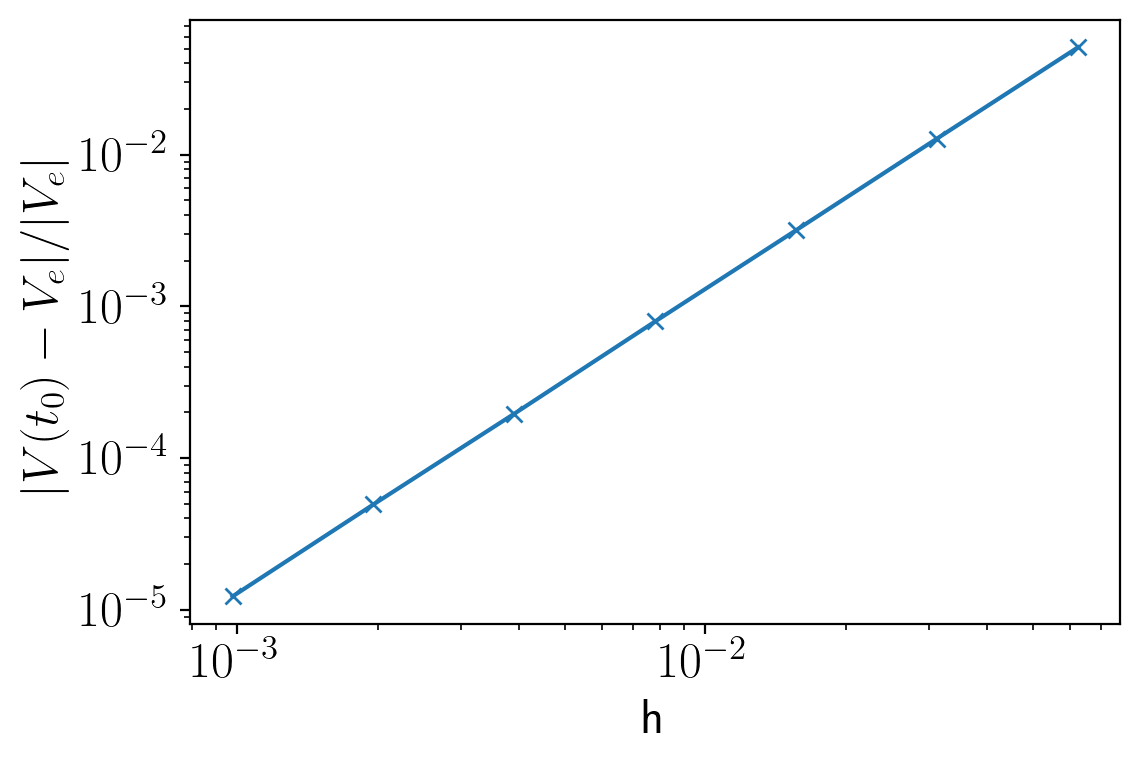

In [8]:
heaviside_dframe = agglomerate_dframe(csv_filename="leiaSetFields.csv",
                                      study_pattern="shear2DindicatorHeaviside",
                                      dframe_name="heaviside")

print ("Exact volume %e" % V_e)
print ("Marker model volume")
print (heaviside_dframe["VOL_ALPHA_0"])
volume_error_heaviside = abs(heaviside_dframe["VOL_ALPHA_0"] - V_e) / V_e
print ("Volume error for heaviside")
print (volume_error_heaviside)
plt.plot(heaviside_dframe["H"], volume_error_heaviside, '-x')
plt.ylabel("$|V(t_0) - V_e|/|V_e|$")
plt.xlabel("h")
plt.loglog()
plt.savefig("leiaLevelSetFoam-heaviside-V0-error.pdf", bbox_inches="tight")

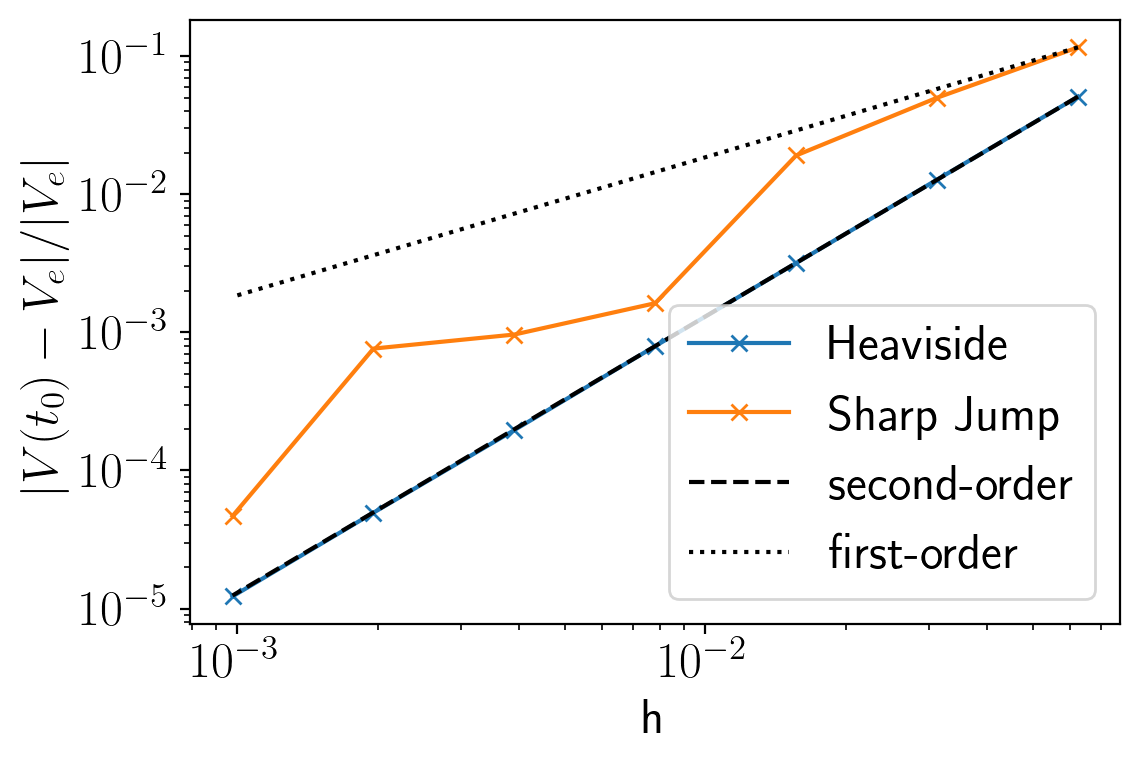

In [9]:
plt.plot(heaviside_dframe["H"], volume_error_heaviside, '-x', label="Heaviside")
plt.plot(sharpJump_dframe["H"], volume_error_sharpJump, '-x', label="Sharp Jump")

h_01 = [heaviside_dframe["H"].iloc[0],heaviside_dframe["H"].iloc[-1]]
heaviside_01 = [volume_error_heaviside.iloc[0], 
               volume_error_heaviside.iloc[0]*(h_01[1]/h_01[0])**2]
sharpJump_01 = [volume_error_sharpJump.iloc[0], 
                volume_error_sharpJump.iloc[0]*(h_01[1]/h_01[0])] 
plt.plot(h_01,heaviside_01,"k--",label="second-order")
plt.plot(h_01,sharpJump_01,"k:",label="first-order")
plt.ylabel("$|V(t_0) - V_e|/|V_e|$")
plt.xlabel("h")
plt.loglog()
plt.legend()
plt.savefig("leiaLevelSetFoam-comparison-V0-error.pdf", bbox_inches="tight")

# shear2D verification case

A circle of radius $R=0.15$ is placed in a unit-square domain at $C=(0.75, 0.5)$ and advected with the velocity 

$$
        \mathbf{v} = \cos \left(\frac{\pi t}{T}\right) \left[ \begin{matrix} 
            \sin(2\pi y)\sin^2(\pi x) \\ 
            -\sin(2\pi x)\sin^2(\pi y) \\ 
            0
        \end{matrix}\right]
$$

that reverses the flow after $t=0.5T$. Rate of convergence is reported for the absolute error $|\phi_c^{T} - \phi_c^{0}|$ in the $L_\infty$ norm
$$
             e_\phi^\infty = \max_{c \in C} |\phi^{t_e}_c - \phi^0_c|,
$$
with $t_e = T$ and $C$ being the index-set of all mesh cells. The rate of convergence is computed with respect to the discretization length $h$
$$
                h := \max_{f \in F} \| \mathbf{d}_f \|, 
$$
where $F$ is the index-set of all mesh faces.

# $|V(t_e) - V_e|/|V_e|$ - volume conservation error

In [10]:
shear2D_dframe = agglomerate_dframe(csv_filename="leiaLevelSetFoam.csv",
                                    study_pattern="shear2Dadvection",
                                    dframe_name="shear2Dadvection")
print(shear2D_dframe)

['shear2Dadvection_00000_shear2D/leiaLevelSetFoam.csv', 'shear2Dadvection_00001_shear2D/leiaLevelSetFoam.csv', 'shear2Dadvection_00002_shear2D/leiaLevelSetFoam.csv']
           H  L_INF_E_PHI  L_INF_E_GRAD_PHI  E_VOL_ALPHA  E_GEOM_ALPHA  \
0  0.0312500   0.00028094         0.9787473   0.00020275    0.00000197   
1  0.0156250   0.00056022         0.9894752   0.00019933    0.00000197   
2  0.0078125   0.00106709         0.9947648   0.00019786    0.00000198   

   E_BOUND_ALPHA  VOL_ALPHA_0  
0              0   0.00715877  
1              0   0.00709103  
2              0   0.00707421  
